In [1]:
import os
import sys
import pandas as pd
import numpy as np

# For notebooks — get the current working directory
notebook_dir = os.getcwd()
project_dir = os.path.abspath(os.path.join(notebook_dir, '..'))
sys.path.append(project_dir)

# Then import your module
#import Utils.functions as data_viz
import Utils.file_io as file_io

from dotenv import load_dotenv
load_dotenv()


False

In [2]:
#import re
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, auc, precision_recall_curve, confusion_matrix, log_loss, brier_score_loss
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Input, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
#import tensorflow.keras.backend as K
import tensorflow as tf
from keras.metrics import AUC#, Precision, Recall
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

2025-07-26 17:03:22.449813: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-26 17:03:27.102845: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-26 17:03:29.029768: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753549412.613036    2050 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753549413.473266    2050 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753549420.884205    2050 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

# Initialization

In [ ]:
#File imports and initialization
file_path = f"{project_dir}/Notebooks/Dataset/data_features"
file_path_0 = f"{project_dir}/Dataset/data_features"
file_path_1 = f"{project_dir}/Dataset/"

df_features_daily = file_io.input_csv(f"{file_path}_daily")
df_features_weekly = file_io.input_csv(f"{file_path}_weekly")
df_features_monthly = file_io.input_csv(f"{file_path}_monthly")

#recessions = pd.read_csv(f"{project_dir}/Dataset/recession_periods.csv")
recessions = file_io.input_csv(f"{project_dir}/Dataset/recession_periods")
#recessions = pd.read_csv(f"{project_dir}/Dataset/recession_periods.csv1")

dict_features = {'Daily': df_features_daily,
                 'Weekly': df_features_weekly,
                 'Monthly': df_features_monthly
} 

train_test_split = pd.to_datetime('2015-01-01')
split_at = train_test_split
split_at_num = mdates.date2num(split_at)

export_config = {'Print Out For all models': 
                  {'print': False},
                 'Save Probability Plots as PNG': 
                  {'save': False},
                 'Export AUC Report to CSV': 
                  {'save': False},
                 'All or Test dataset for plots': 
                  {'print': False}                  
}

seed = 42
import random
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
#tf.config.experimental.enable_op_determinism()

DataFrame loaded from /workspaces/RecessionPredictionML/Notebooks/Dataset/data_features_daily.csv
DataFrame loaded from /workspaces/RecessionPredictionML/Notebooks/Dataset/data_features_weekly.csv
DataFrame loaded from /workspaces/RecessionPredictionML/Notebooks/Dataset/data_features_monthly.csv


### Required Functions

In [4]:
# Required Functions
# Refactor
def binary_focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss(y_true, y_pred):
        eps = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, eps, 1. - eps)
        
        cross_entropy = - (y_true * tf.math.log(y_pred) + (1 - y_true) * tf.math.log(1 - y_pred))
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        alpha_factor = y_true * alpha + (1 - y_true) * (1 - alpha)
        modulating_factor = tf.pow(1.0 - p_t, gamma)

        loss = alpha_factor * modulating_factor * cross_entropy
        return tf.reduce_mean(loss)
    
    return focal_loss

def make_sequences(X, y=None, seq_len=12):
    X_seq, y_seq, timestamps = [], [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X.iloc[i:i+seq_len].values)
        timestamps.append(X.index[i+seq_len])
        #print(timestamps)
        if y is not None:
            y_seq.append(y.iloc[i+seq_len])

    X_seq = np.array(X_seq)
    return (X_seq, np.array(y_seq)) if y is not None else (X_seq, None)


def get_class_weight(y_train):
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
    class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}
    alpha = class_weights[1] / (class_weights[0] + class_weights[1])
    return class_weights_dict, alpha
    
    
def scaling_features(train,test, scaler_func = StandardScaler()):
    scaler = scaler_func
    X_train = train
    X_test = test
    n_train, seq_len, n_feat = X_train.shape
    n_test,      _   ,  _    = X_test.shape
    if scaler_func is None:
        return X_train, X_test, seq_len, n_feat

    X_train_scaled = scaler.fit_transform(X_train.reshape(-1, n_feat)).reshape(n_train, seq_len, n_feat)
    X_test_scaled  = scaler.transform    (X_test.reshape(-1, n_feat)).reshape(n_test, seq_len, n_feat)

    return X_train_scaled, X_test_scaled, seq_len, n_feat, scaler



def layer_sizes(str_var):
    #str_var = 'LSTM_4_2'
    parts = str_var.split('_')
    int_list = [int(x) for x in parts[1:]]
    model_type = parts[0]
    return int_list, model_type
    

### Derivative Functions for Model setup

In [5]:

def LSTM_Model_init(model_name, seq_len, n_feat, alpha):

    layer_size, model_type = layer_sizes(model_name)

    is_bi = model_type.upper().startswith("BILSTM")

    #Build model
    model = Sequential()
    model.add(Input(shape=(seq_len, n_feat)))
    

    for i, units in enumerate(layer_size):
        return_seq = (i < len(layer_size) - 1)
        lstm_layer = LSTM(units, return_sequences=return_seq)

        if is_bi:
            # wrap in Bidirectional
            model.add(Bidirectional(lstm_layer))
        else:
            model.add(lstm_layer)
        
        model.add(Dropout(0.3))
    # stuff
    model.add(Dense(1, activation="sigmoid"))

    model.compile(
        optimizer="adam",
        loss=binary_focal_loss(gamma=2.0, alpha=alpha),
        #metrics=["accuracy"]
        metrics=[#"Precision", "Recall", #"AUC"]
                    AUC(name='AUC-ROC', curve = 'ROC'),
                    AUC(name='AUC-PR', curve='PR')]
    )

    return model

#early_stop = EarlyStopping(monitor="val_Recall", patience=10, restore_best_weights=True, mode='max')

def LSTM_Model_train(train, test, early_stop, model, class_weights, verbose = 0):
    X_train_scaled, y_train = train[0], train[1]
    X_test_scaled, y_test = test[0], test[1]
    callback_list = [early_stop] if early_stop is not None else []
    history = model.fit(
        X_train_scaled, y_train,
        validation_split=0.2,
        epochs=50, batch_size=32, #change to 30
        callbacks=callback_list,
        class_weight=class_weights,
        verbose=verbose#, shuffle = False
    )

    #X_all_scaled = np.concatenate([X_train_scaled, X_test_scaled], axis=0) #pd.concat([X_train_scaled, X_test_scaled])
    #probs_all = model.predict(X_all_scaled, verbose=verbose).reshape(-1)
    epochs = len(history.history['loss'])

    probs = model.predict(X_test_scaled, verbose=verbose).reshape(-1)
    probs_all = probs
    return model, epochs, probs_all

def LSTM_Model_evaluate(test, probs, threshold = None):
    X_test_scaled, y_test = test[0], test[1]
    if threshold is None:
        threshold = 0.001
    y_pred = (probs >= threshold).astype(int)

    precision, recall, thresholds = precision_recall_curve(y_test, probs)
    #cm = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=["No Recession", "Recession"], output_dict=True, zero_division=0)
    report["auc_pr"] = auc(recall, precision)
    ap_score = average_precision_score(y_test, probs)
    report["ap_score"]=  ap_score
    report["ap_score_inverted"] = 1-ap_score
    report["auc_roc"]= roc_auc_score(y_test, probs)
    report["log_loss"] = log_loss(y_test, probs)
    report["brier_score_loss"] = brier_score_loss(y_test, probs)


    #epochs = len(history.history['loss'])
    return report




## LSTMs of Choice

In [ ]:
#https://onlinegdb.com/4mIJCL7yU
#https://onlinegdb.com/LBeuKhjo_

In [ ]:
LSTM_models = ['LSTM_2_1','LSTM_2_2']
LSTM_models.extend(['LSTM_4_1', 'LSTM_4_2', 'LSTM_4_4'])
#LSTM_models.extend(['LSTM_8_1', 'LSTM_8_2', 'LSTM_8_4', 'LSTM_8_8'])
#LSTM_models = ['LSTM_8_1', 'LSTM_8_2', 'LSTM_8_4', 'LSTM_8_8']
#LSTM_models = ['LSTM_2_1','LSTM_2_2']
#LSTM_models.extend(['BiLSTM_32_16', 'BiLSTM_64_32', 'BiLSTM_96_48', 'BiLSTM_128_64'])
print(LSTM_models)
LSTM_results = {}
early_stop = EarlyStopping(monitor="val_AUC-ROC", patience=10, restore_best_weights=True, mode='max')

['LSTM_2_1', 'LSTM_2_2', 'LSTM_4_1', 'LSTM_4_2', 'LSTM_4_4']


In [7]:
for time_freq, df in dict_features.items():
    X = df.drop(columns='recession')
    y = df['recession'] 

    # Train-test split
    #split_at = pd.to_datetime('2015-01-01')
    X_train, X_test = X[X.index < split_at], X[X.index >= split_at]
    y_train, y_test = y[y.index < split_at].astype(int), y[y.index >= split_at].astype(int)

    # Convert to sequences
    seq_len = 32
    X_train_seq, y_train_seq = make_sequences(X_train, y_train, seq_len)
    X_test_seq, y_test_seq = make_sequences(X_test, y_test, seq_len)

    X_train_scaled, X_test_scaled, _, n_feat, scaler = scaling_features(X_train_seq, X_test_seq) #one time calculation per time_freq?
    class_weights_dict, alpha = get_class_weight(y_train_seq) # one time calculation per time_freq?

    LSTM_results[time_freq] = {}
    for model_name in LSTM_models:
        LSTM_results[time_freq][model_name] = {}
        #print(model_name)
        #tf.keras.utils.set_random_seed(seed)
        model_init = LSTM_Model_init(model_name, seq_len, n_feat, alpha)
        #print('Done with Init')
        model, epoch, probs = LSTM_Model_train(train = [X_train_scaled,y_train_seq], test = [X_test_scaled, y_test_seq], 
                         model = model_init, early_stop = early_stop, class_weights = class_weights_dict, 
                         verbose = 0)
        print(f'Done with training {model_name} with {epoch} epochs on {time_freq} data')
        report = LSTM_Model_evaluate(test = [_, y_test_seq], probs = probs, threshold = 0.5)  
        
        #LSTM_results[time_freq][model_name]['probs'] = probs_all
        LSTM_results[time_freq][model_name]['scaler'] = scaler
        LSTM_results[time_freq][model_name]['report'] = report
        LSTM_results[time_freq][model_name]['epoch'] = epoch
        LSTM_results[time_freq][model_name]['model'] = model




2025-07-26 17:03:58.123989: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Done with training LSTM_2_1 with 11 epochs on Daily data
Done with training LSTM_2_2 with 11 epochs on Daily data
Done with training LSTM_4_1 with 14 epochs on Daily data
Done with training LSTM_4_2 with 15 epochs on Daily data
Done with training LSTM_4_4 with 26 epochs on Daily data
Done with training LSTM_2_1 with 11 epochs on Weekly data
Done with training LSTM_2_2 with 50 epochs on Weekly data
Done with training LSTM_4_1 with 11 epochs on Weekly data
Done with training LSTM_4_2 with 11 epochs on Weekly data
Done with training LSTM_4_4 with 11 epochs on Weekly data
Done with training LSTM_2_1 with 42 epochs on Monthly data
Done with training LSTM_2_2 with 36 epochs on Monthly data
Done with training LSTM_4_1 with 14 epochs on Monthly data
Done with training LSTM_4_2 with 13 epochs on Monthly data
Done with training LSTM_4_4 with 24 epochs on Monthly data


In [8]:
if True:#export_config['Print Out For all models']['print']:
    for time_freq in LSTM_results.keys():
        for model_name in LSTM_results[time_freq].keys():
            print(f"\n=== {time_freq} | {model_name} ===")
            #print("Confusion Matrix:\n", LSTM_results[time_freq][f'{model_name}_confusion_matrix'])
            print("Classification Report:")
            print(pd.DataFrame(LSTM_results[time_freq][model_name]['report']).transpose())


=== Daily | LSTM_2_1 ===
Classification Report:
                   precision    recall  f1-score      support
No Recession        1.000000  0.100041  0.181886  2439.000000
Recession           0.126194  1.000000  0.224107   317.000000
accuracy            0.203556  0.203556  0.203556     0.203556
macro avg           0.563097  0.550021  0.202997  2756.000000
weighted avg        0.899493  0.203556  0.186742  2756.000000
auc_pr              0.142790  0.142790  0.142790     0.142790
ap_score            0.143252  0.143252  0.143252     0.143252
ap_score_inverted   0.856748  0.856748  0.856748     0.856748
auc_roc             0.648543  0.648543  0.648543     0.648543
log_loss            0.711036  0.711036  0.711036     0.711036
brier_score_loss    0.258941  0.258941  0.258941     0.258941

=== Daily | LSTM_2_2 ===
Classification Report:
                   precision    recall  f1-score      support
No Recession        1.000000  0.088151  0.162020  2439.000000
Recession           0.124754  1.00

In [9]:
#ignore
var = LSTM_results['Daily']#['LSTM_4_4']#['epoch']
print(var)
print(len(var))

for key in var.keys():
    print(key)

{'LSTM_2_1': {'scaler': StandardScaler(), 'report': {'No Recession': {'precision': 1.0, 'recall': 0.1000410004100041, 'f1-score': 0.18188594856503915, 'support': 2439.0}, 'Recession': {'precision': 0.12619426751592358, 'recall': 1.0, 'f1-score': 0.224107458465889, 'support': 317.0}, 'accuracy': 0.20355587808417996, 'macro avg': {'precision': 0.5630971337579618, 'recall': 0.550020500205002, 'f1-score': 0.20299670351546406, 'support': 2756.0}, 'weighted avg': {'precision': 0.8994933174174702, 'recall': 0.20355587808417996, 'f1-score': 0.18674234139470872, 'support': 2756.0}, 'auc_pr': np.float64(0.14279009352542515), 'ap_score': np.float64(0.14325190601905696), 'ap_score_inverted': np.float64(0.8567480939809431), 'auc_roc': np.float64(0.6485430627176934), 'log_loss': 0.7110355887349001, 'brier_score_loss': np.float64(0.25894063229341235)}, 'epoch': 11, 'model': <Sequential name=sequential, built=True>}, 'LSTM_2_2': {'scaler': StandardScaler(), 'report': {'No Recession': {'precision': 1.0

In [10]:
plot_all = True

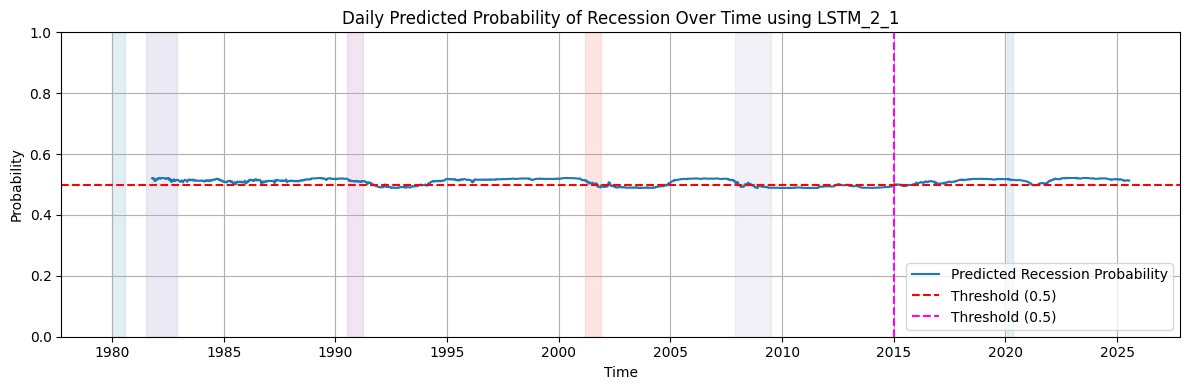

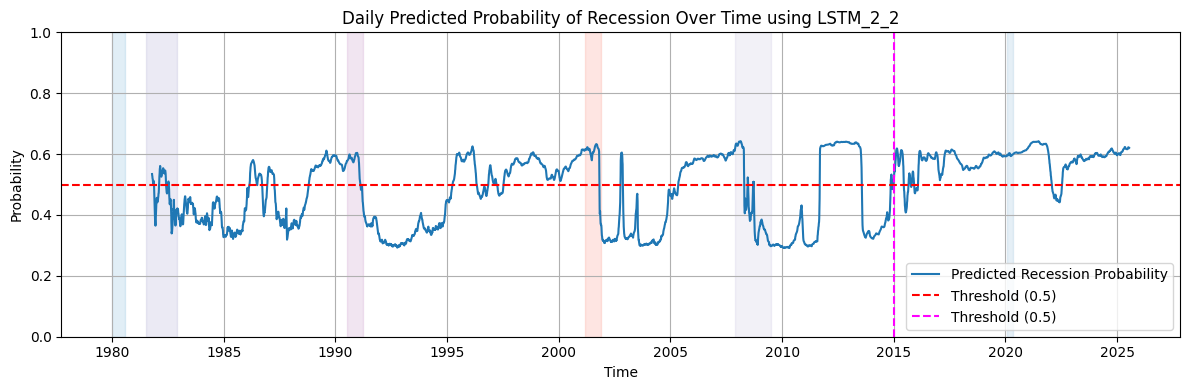

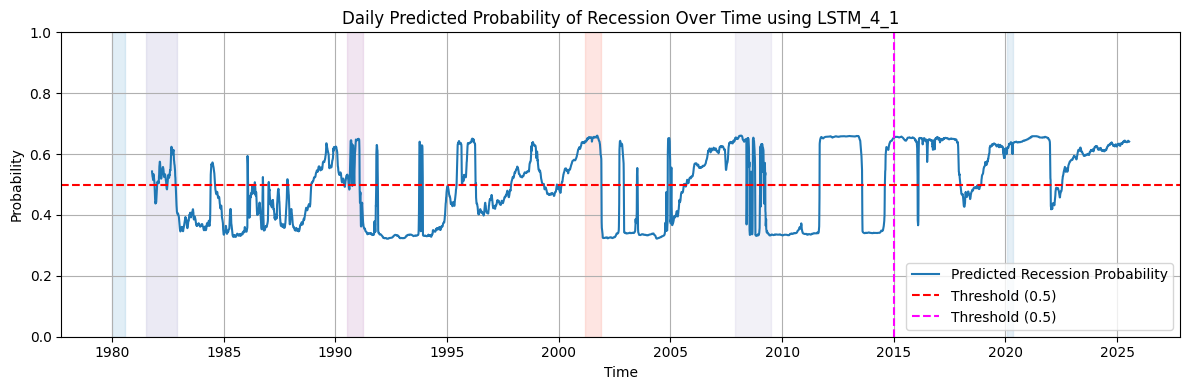

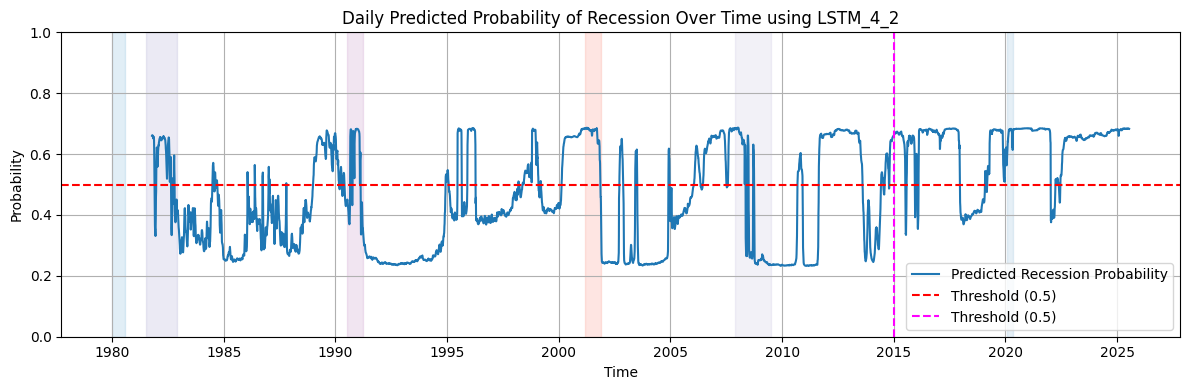

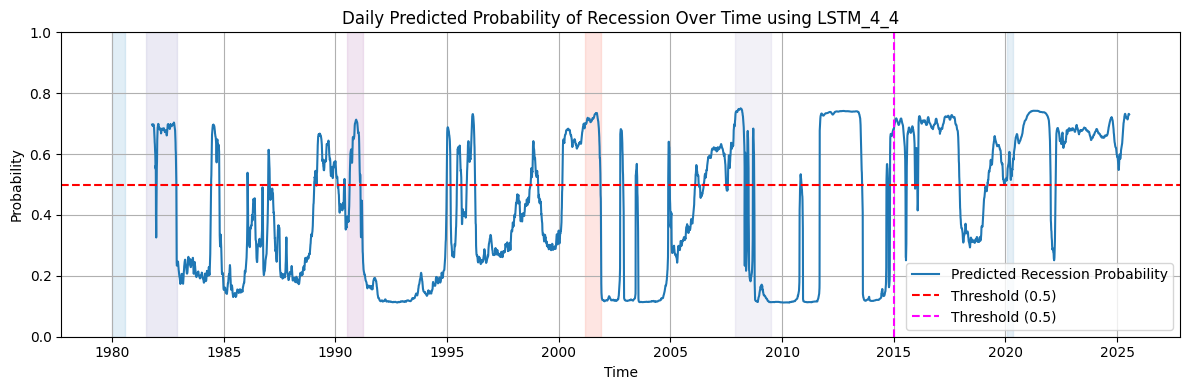

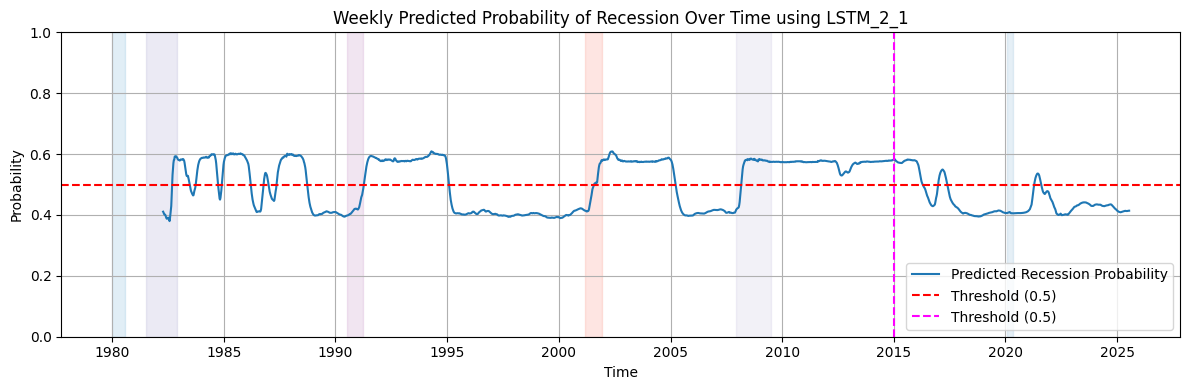

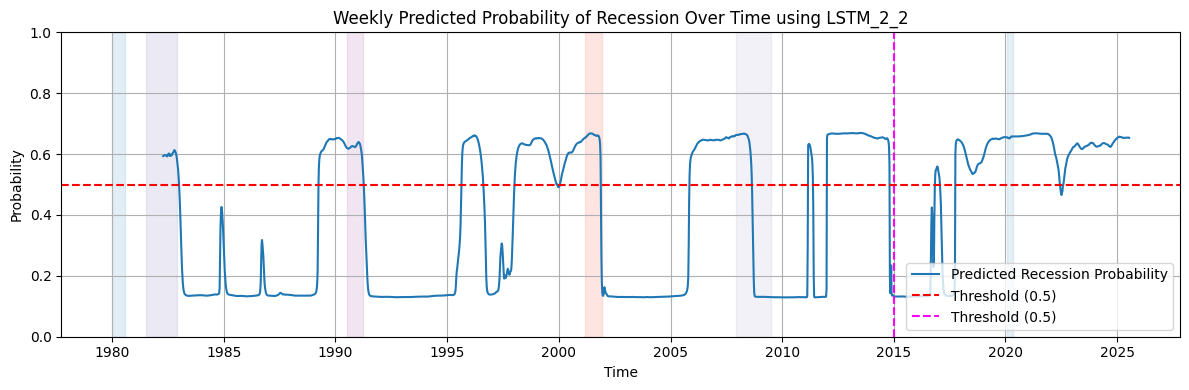

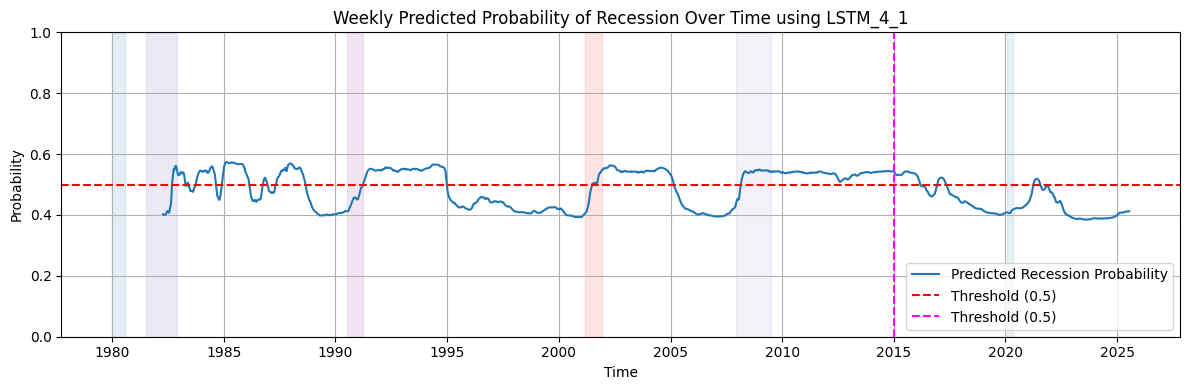

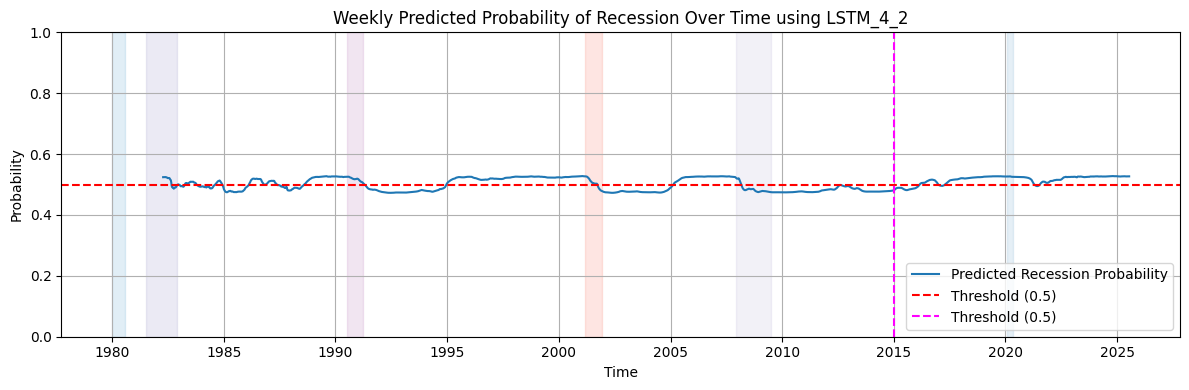

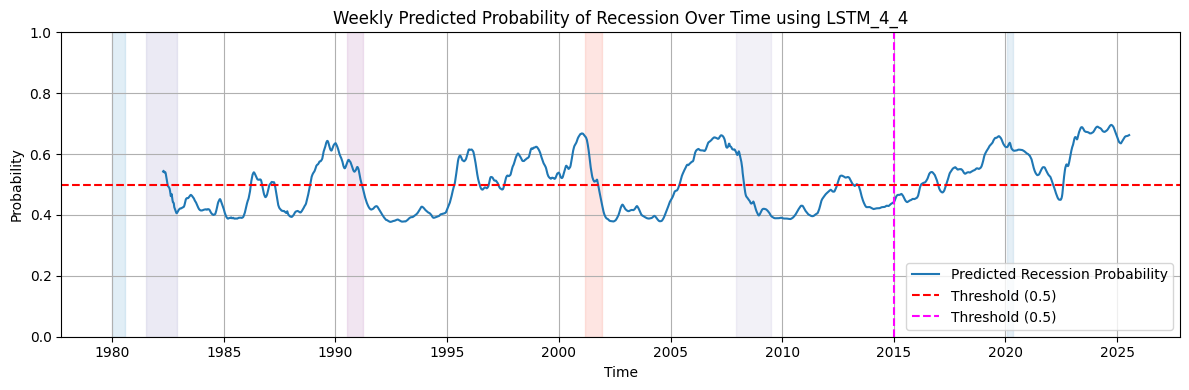

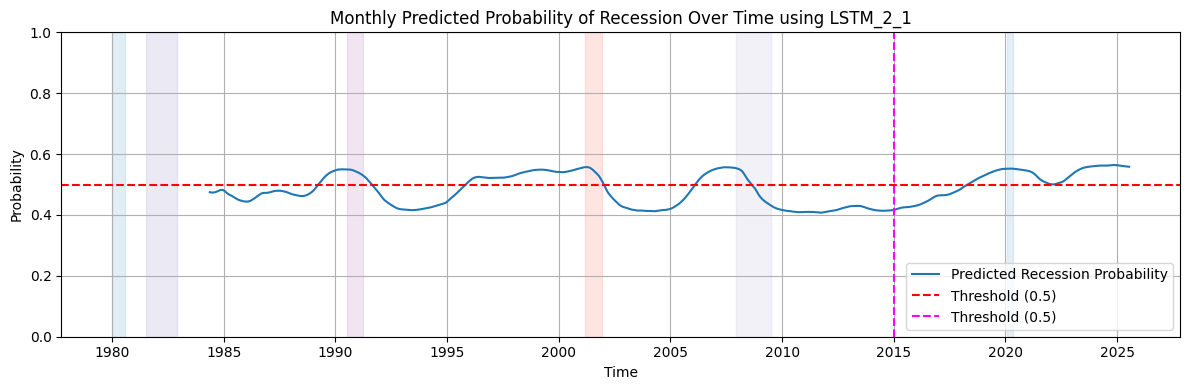

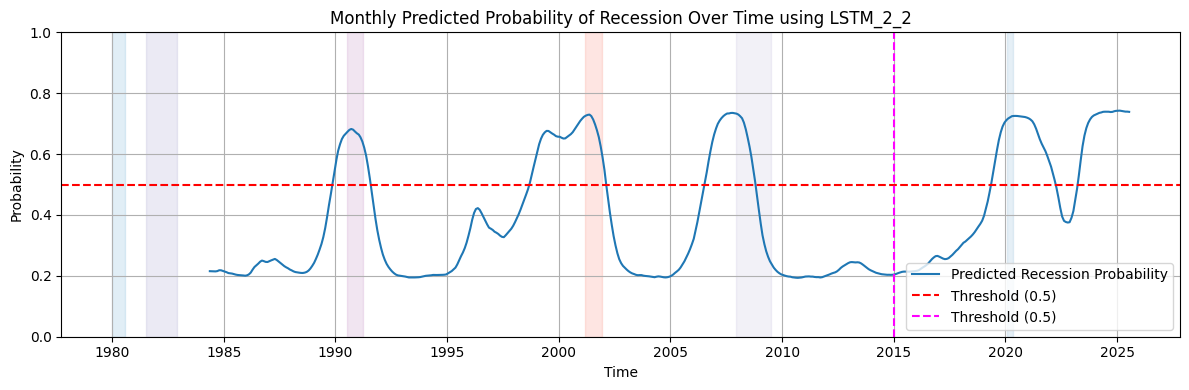

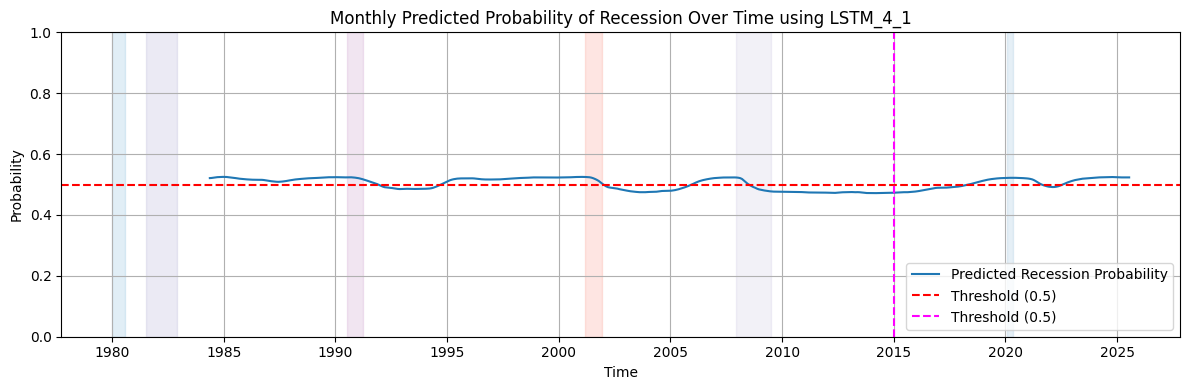

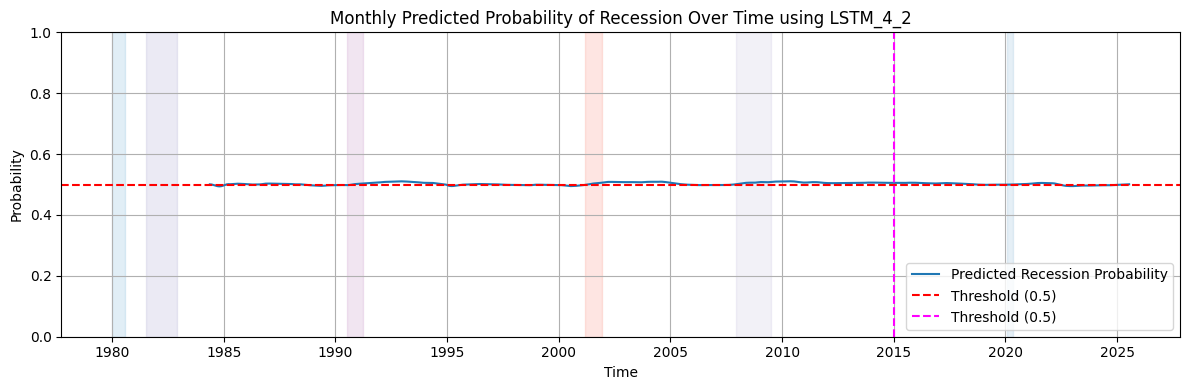

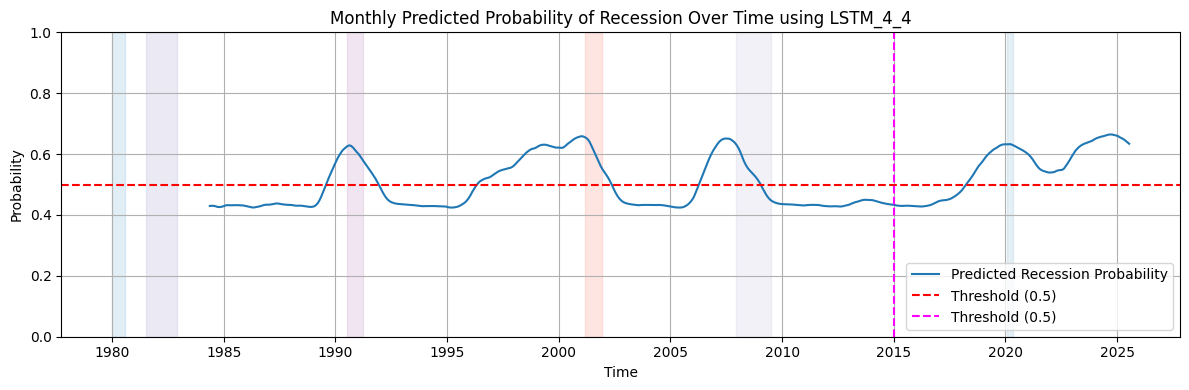

In [11]:
plot_all = True
for time_freq, df in dict_features.items():
    X = df.drop(columns='recession')
    y = df['recession']

    # Train-test split
    #split_at = pd.to_datetime('2015-01-01')
    #X_train, X_test = X[X.index < split_at], X[X.index >= split_at]
    #y_train, y_test = y[y.index < split_at].astype(int), y[y.index >= split_at].astype(int)
    X_test = X[X.index >= split_at]
    X_all = X
    
    for model_name in LSTM_models:
        model = LSTM_results[time_freq][model_name]['model']
        scaler = LSTM_results[time_freq][model_name]['scaler']
        
        X_test_seq, _ = make_sequences(X_test, y=None, seq_len=seq_len)
        X_test_scaled = scaler.transform(X_test_seq.reshape(-1, X_test.shape[1])).reshape(X_test_seq.shape)
        X_all_seq, _ = make_sequences(X_all, y=None, seq_len=seq_len)
        X_all_scaled = scaler.transform(X_all_seq.reshape(-1, X_all.shape[1])).reshape(X_all_seq.shape)

        #if 
        probs_all = model.predict(X_all_scaled, verbose=0)
        dates_all = X_all.index[seq_len:]
        prob_series = pd.Series(probs_all.flatten(), index=dates_all)



        fig, ax = plt.subplots(figsize=(12, 4))
        ax.plot(prob_series, label='Predicted Recession Probability')
        ax.axhline(y=0.5, color='r', linestyle='--', label='Threshold (0.5)')
        split_at = train_test_split
        ax.axvline(x=split_at, color='magenta', linestyle='--', label='Threshold (0.5)')

        if recessions is not None:
            for row in recessions.itertuples(index=False):
                ax.axvspan(pd.to_datetime(row.start), pd.to_datetime(row.end), color=row.color, alpha=0.2)

        ax.set_title(f'{time_freq} Predicted Probability of Recession Over Time using {model_name}')
        ax.set_xlabel('Time')
        ax.set_ylabel('Probability')
        ax.set_ylim(0, 1)
        ax.legend(loc='lower right')
        ax.grid(True)
        plt.tight_layout()
        plt.show()




X_test_seq: 95 vs X_test_scaled: 95
X_all_seq: 11567 vs X_all_scaled: 11567


       start        end    color         recession_label
0 1980-01-01 1980-07-31  #6BAED6             'Oil Shock'
1 1981-07-01 1982-11-30  #9E9AC8         'Volcker Shock'
2 1990-07-01 1991-03-31  #BC80BD       'Oil Price Spike'
3 2001-03-01 2001-11-30  #FB8072  'Dot-com Bubble Burst'
4 2007-12-01 2009-06-30  #BEBADA      'Housing Collapse'
5 2020-02-01 2020-04-30  #80B1D3     'COVID-19 Pandemic'


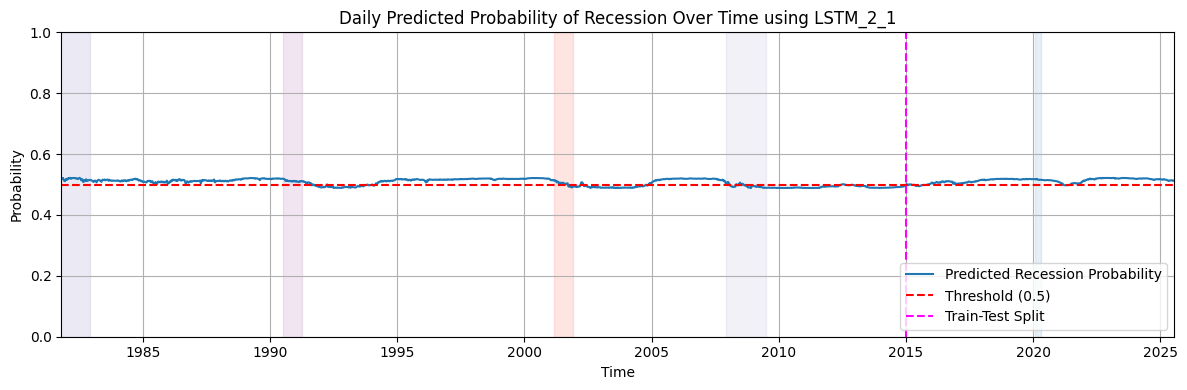

X_test_seq: 95 vs X_test_scaled: 95
X_all_seq: 11567 vs X_all_scaled: 11567
       start        end    color         recession_label
0 1980-01-01 1980-07-31  #6BAED6             'Oil Shock'
1 1981-07-01 1982-11-30  #9E9AC8         'Volcker Shock'
2 1990-07-01 1991-03-31  #BC80BD       'Oil Price Spike'
3 2001-03-01 2001-11-30  #FB8072  'Dot-com Bubble Burst'
4 2007-12-01 2009-06-30  #BEBADA      'Housing Collapse'
5 2020-02-01 2020-04-30  #80B1D3     'COVID-19 Pandemic'


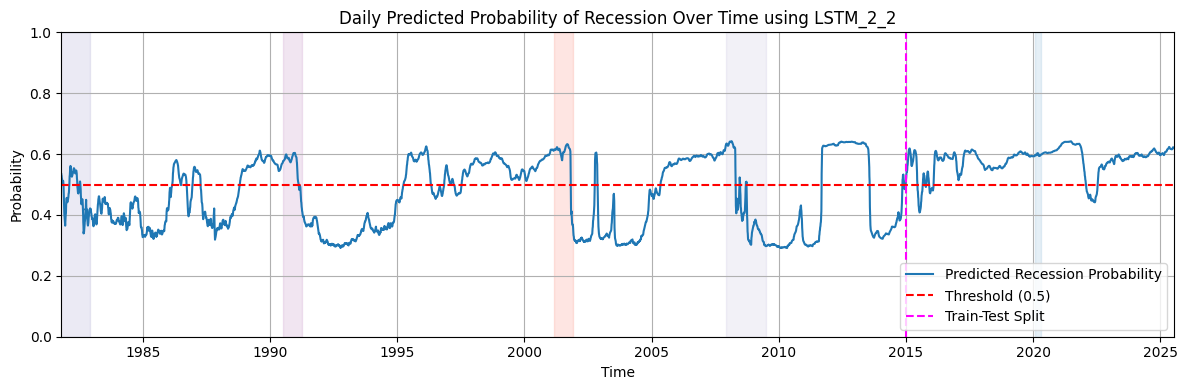

X_test_seq: 95 vs X_test_scaled: 95
X_all_seq: 11567 vs X_all_scaled: 11567
       start        end    color         recession_label
0 1980-01-01 1980-07-31  #6BAED6             'Oil Shock'
1 1981-07-01 1982-11-30  #9E9AC8         'Volcker Shock'
2 1990-07-01 1991-03-31  #BC80BD       'Oil Price Spike'
3 2001-03-01 2001-11-30  #FB8072  'Dot-com Bubble Burst'
4 2007-12-01 2009-06-30  #BEBADA      'Housing Collapse'
5 2020-02-01 2020-04-30  #80B1D3     'COVID-19 Pandemic'


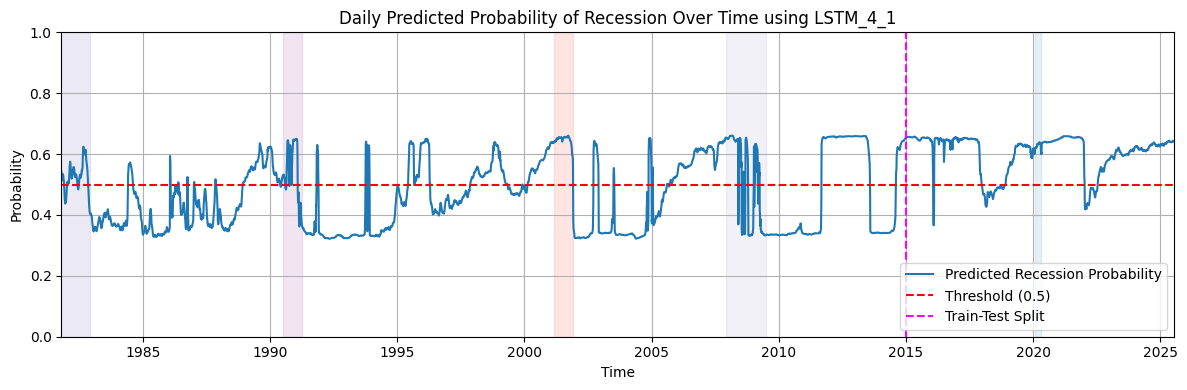

X_test_seq: 95 vs X_test_scaled: 95
X_all_seq: 11567 vs X_all_scaled: 11567
       start        end    color         recession_label
0 1980-01-01 1980-07-31  #6BAED6             'Oil Shock'
1 1981-07-01 1982-11-30  #9E9AC8         'Volcker Shock'
2 1990-07-01 1991-03-31  #BC80BD       'Oil Price Spike'
3 2001-03-01 2001-11-30  #FB8072  'Dot-com Bubble Burst'
4 2007-12-01 2009-06-30  #BEBADA      'Housing Collapse'
5 2020-02-01 2020-04-30  #80B1D3     'COVID-19 Pandemic'


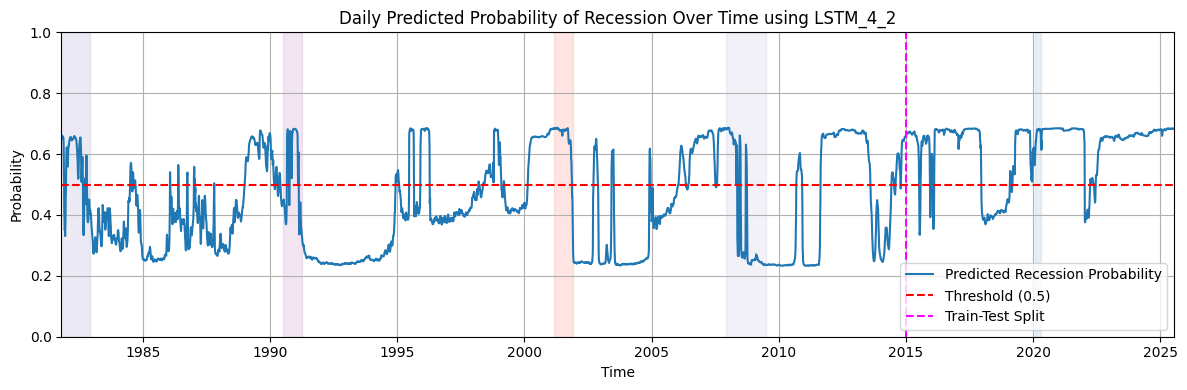

X_test_seq: 95 vs X_test_scaled: 95
X_all_seq: 11567 vs X_all_scaled: 11567
       start        end    color         recession_label
0 1980-01-01 1980-07-31  #6BAED6             'Oil Shock'
1 1981-07-01 1982-11-30  #9E9AC8         'Volcker Shock'
2 1990-07-01 1991-03-31  #BC80BD       'Oil Price Spike'
3 2001-03-01 2001-11-30  #FB8072  'Dot-com Bubble Burst'
4 2007-12-01 2009-06-30  #BEBADA      'Housing Collapse'
5 2020-02-01 2020-04-30  #80B1D3     'COVID-19 Pandemic'


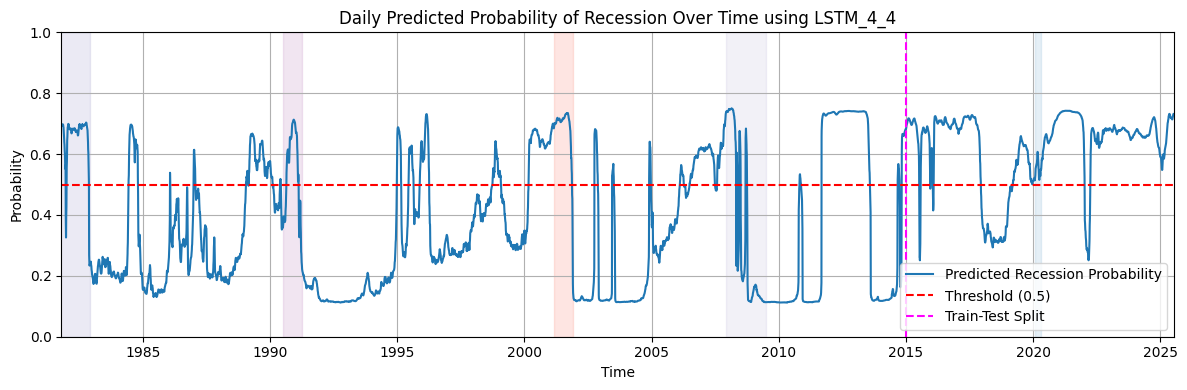

X_test_seq: 95 vs X_test_scaled: 95
X_all_seq: 2258 vs X_all_scaled: 2258
       start        end    color         recession_label
0 1980-01-01 1980-07-31  #6BAED6             'Oil Shock'
1 1981-07-01 1982-11-30  #9E9AC8         'Volcker Shock'
2 1990-07-01 1991-03-31  #BC80BD       'Oil Price Spike'
3 2001-03-01 2001-11-30  #FB8072  'Dot-com Bubble Burst'
4 2007-12-01 2009-06-30  #BEBADA      'Housing Collapse'
5 2020-02-01 2020-04-30  #80B1D3     'COVID-19 Pandemic'


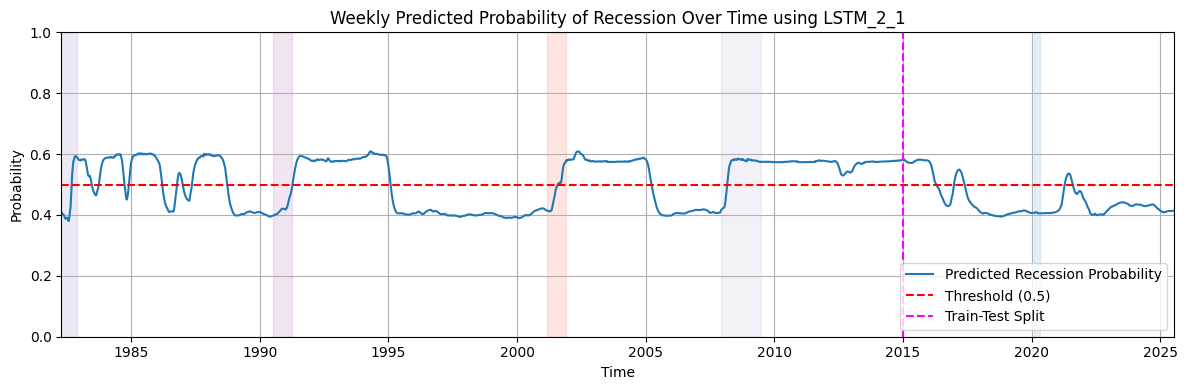

X_test_seq: 95 vs X_test_scaled: 95
X_all_seq: 2258 vs X_all_scaled: 2258
       start        end    color         recession_label
0 1980-01-01 1980-07-31  #6BAED6             'Oil Shock'
1 1981-07-01 1982-11-30  #9E9AC8         'Volcker Shock'
2 1990-07-01 1991-03-31  #BC80BD       'Oil Price Spike'
3 2001-03-01 2001-11-30  #FB8072  'Dot-com Bubble Burst'
4 2007-12-01 2009-06-30  #BEBADA      'Housing Collapse'
5 2020-02-01 2020-04-30  #80B1D3     'COVID-19 Pandemic'


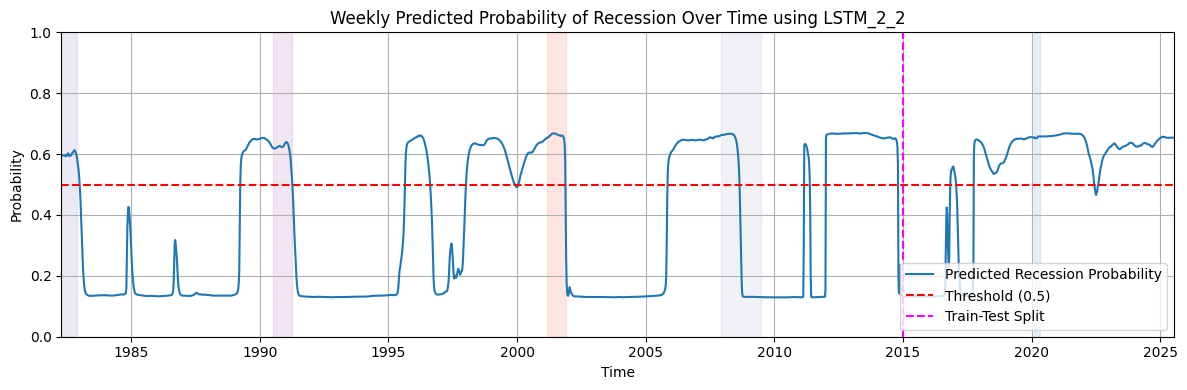

X_test_seq: 95 vs X_test_scaled: 95
X_all_seq: 2258 vs X_all_scaled: 2258
       start        end    color         recession_label
0 1980-01-01 1980-07-31  #6BAED6             'Oil Shock'
1 1981-07-01 1982-11-30  #9E9AC8         'Volcker Shock'
2 1990-07-01 1991-03-31  #BC80BD       'Oil Price Spike'
3 2001-03-01 2001-11-30  #FB8072  'Dot-com Bubble Burst'
4 2007-12-01 2009-06-30  #BEBADA      'Housing Collapse'
5 2020-02-01 2020-04-30  #80B1D3     'COVID-19 Pandemic'


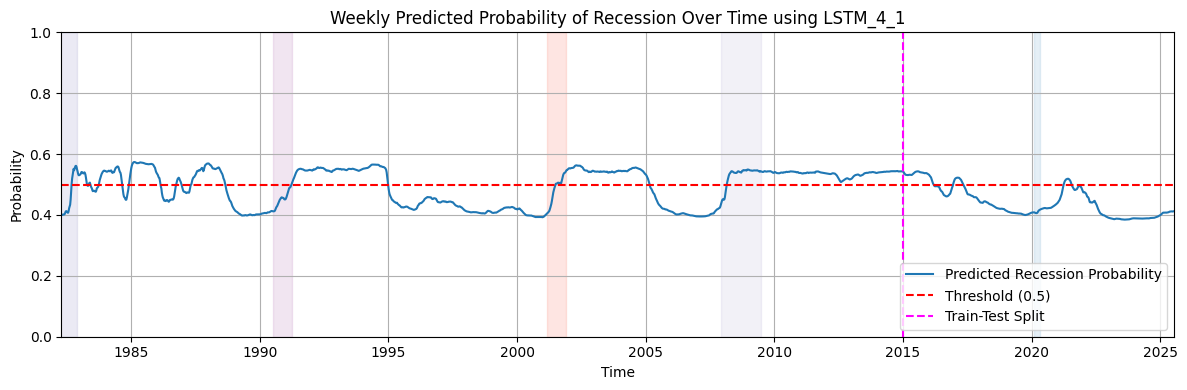

X_test_seq: 95 vs X_test_scaled: 95
X_all_seq: 2258 vs X_all_scaled: 2258
       start        end    color         recession_label
0 1980-01-01 1980-07-31  #6BAED6             'Oil Shock'
1 1981-07-01 1982-11-30  #9E9AC8         'Volcker Shock'
2 1990-07-01 1991-03-31  #BC80BD       'Oil Price Spike'
3 2001-03-01 2001-11-30  #FB8072  'Dot-com Bubble Burst'
4 2007-12-01 2009-06-30  #BEBADA      'Housing Collapse'
5 2020-02-01 2020-04-30  #80B1D3     'COVID-19 Pandemic'


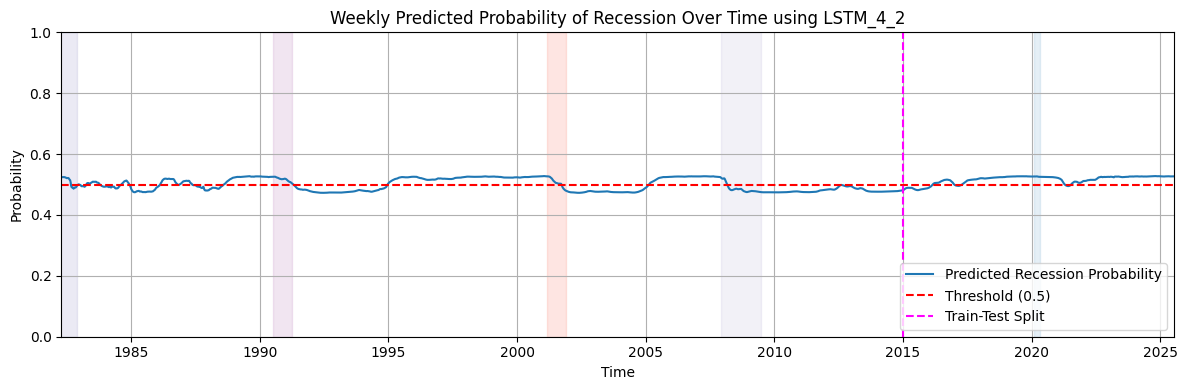

X_test_seq: 95 vs X_test_scaled: 95
X_all_seq: 2258 vs X_all_scaled: 2258
       start        end    color         recession_label
0 1980-01-01 1980-07-31  #6BAED6             'Oil Shock'
1 1981-07-01 1982-11-30  #9E9AC8         'Volcker Shock'
2 1990-07-01 1991-03-31  #BC80BD       'Oil Price Spike'
3 2001-03-01 2001-11-30  #FB8072  'Dot-com Bubble Burst'
4 2007-12-01 2009-06-30  #BEBADA      'Housing Collapse'
5 2020-02-01 2020-04-30  #80B1D3     'COVID-19 Pandemic'


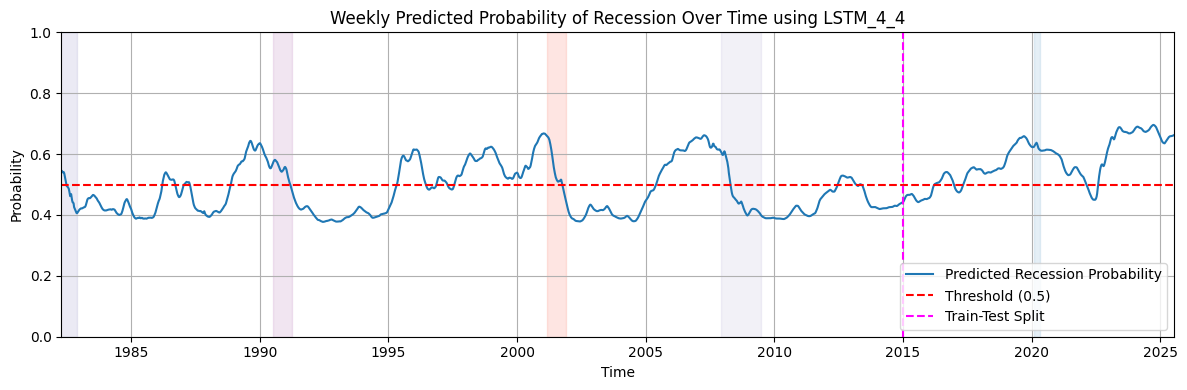

X_test_seq: 95 vs X_test_scaled: 95
X_all_seq: 495 vs X_all_scaled: 495
       start        end    color         recession_label
0 1980-01-01 1980-07-31  #6BAED6             'Oil Shock'
1 1981-07-01 1982-11-30  #9E9AC8         'Volcker Shock'
2 1990-07-01 1991-03-31  #BC80BD       'Oil Price Spike'
3 2001-03-01 2001-11-30  #FB8072  'Dot-com Bubble Burst'
4 2007-12-01 2009-06-30  #BEBADA      'Housing Collapse'
5 2020-02-01 2020-04-30  #80B1D3     'COVID-19 Pandemic'


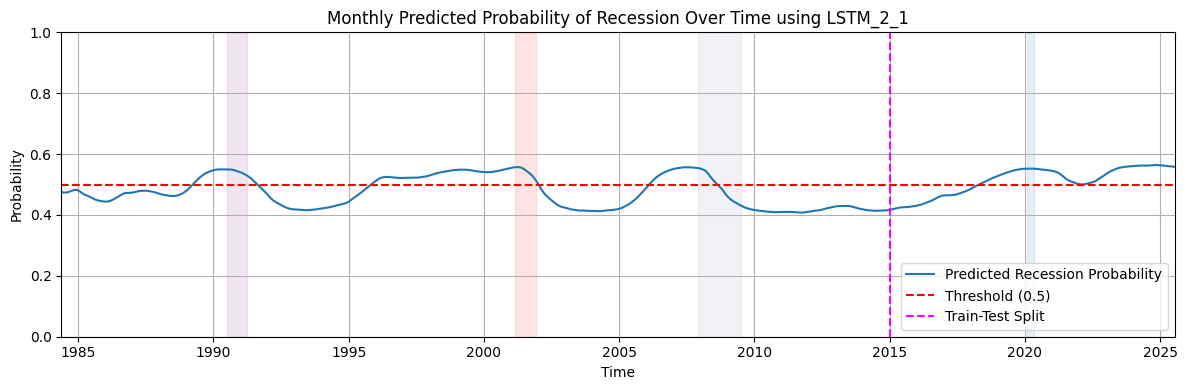

X_test_seq: 95 vs X_test_scaled: 95
X_all_seq: 495 vs X_all_scaled: 495
       start        end    color         recession_label
0 1980-01-01 1980-07-31  #6BAED6             'Oil Shock'
1 1981-07-01 1982-11-30  #9E9AC8         'Volcker Shock'
2 1990-07-01 1991-03-31  #BC80BD       'Oil Price Spike'
3 2001-03-01 2001-11-30  #FB8072  'Dot-com Bubble Burst'
4 2007-12-01 2009-06-30  #BEBADA      'Housing Collapse'
5 2020-02-01 2020-04-30  #80B1D3     'COVID-19 Pandemic'


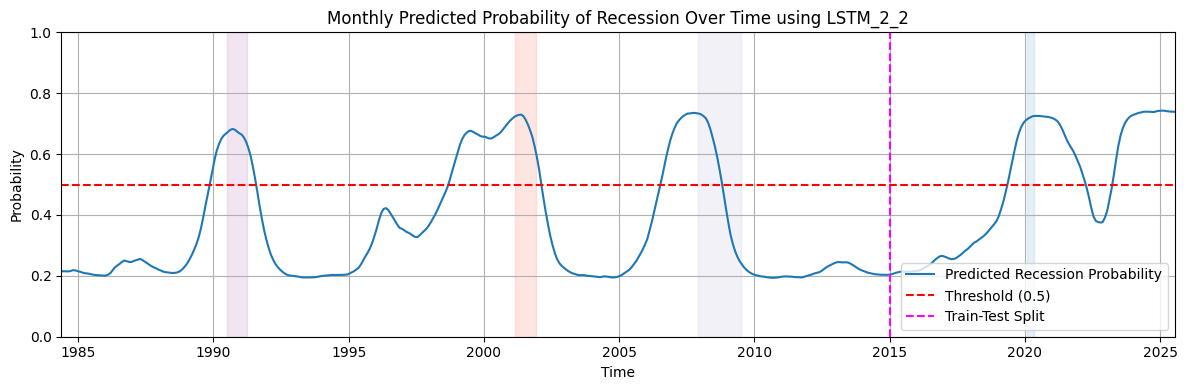

X_test_seq: 95 vs X_test_scaled: 95
X_all_seq: 495 vs X_all_scaled: 495
       start        end    color         recession_label
0 1980-01-01 1980-07-31  #6BAED6             'Oil Shock'
1 1981-07-01 1982-11-30  #9E9AC8         'Volcker Shock'
2 1990-07-01 1991-03-31  #BC80BD       'Oil Price Spike'
3 2001-03-01 2001-11-30  #FB8072  'Dot-com Bubble Burst'
4 2007-12-01 2009-06-30  #BEBADA      'Housing Collapse'
5 2020-02-01 2020-04-30  #80B1D3     'COVID-19 Pandemic'


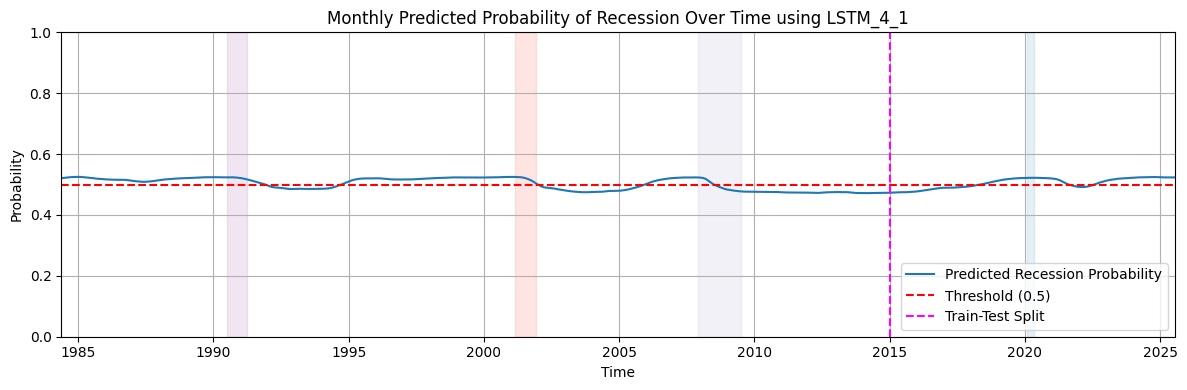

X_test_seq: 95 vs X_test_scaled: 95
X_all_seq: 495 vs X_all_scaled: 495
       start        end    color         recession_label
0 1980-01-01 1980-07-31  #6BAED6             'Oil Shock'
1 1981-07-01 1982-11-30  #9E9AC8         'Volcker Shock'
2 1990-07-01 1991-03-31  #BC80BD       'Oil Price Spike'
3 2001-03-01 2001-11-30  #FB8072  'Dot-com Bubble Burst'
4 2007-12-01 2009-06-30  #BEBADA      'Housing Collapse'
5 2020-02-01 2020-04-30  #80B1D3     'COVID-19 Pandemic'


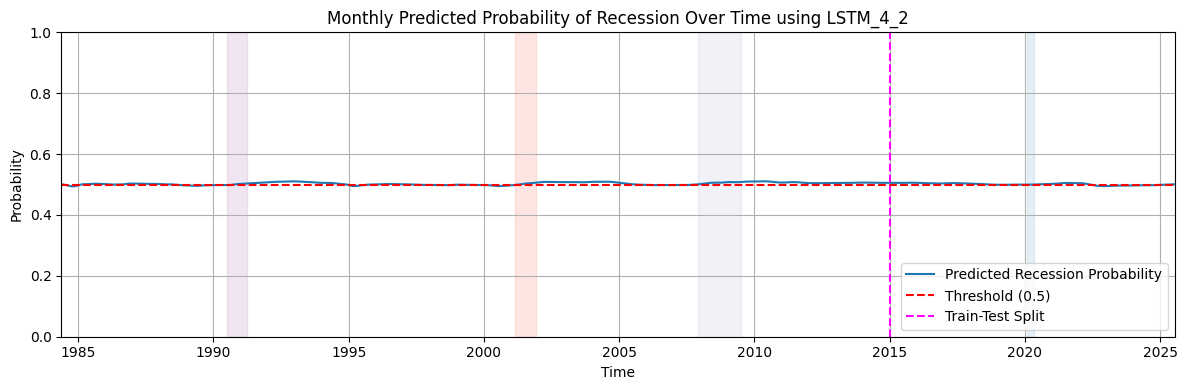

X_test_seq: 95 vs X_test_scaled: 95
X_all_seq: 495 vs X_all_scaled: 495
       start        end    color         recession_label
0 1980-01-01 1980-07-31  #6BAED6             'Oil Shock'
1 1981-07-01 1982-11-30  #9E9AC8         'Volcker Shock'
2 1990-07-01 1991-03-31  #BC80BD       'Oil Price Spike'
3 2001-03-01 2001-11-30  #FB8072  'Dot-com Bubble Burst'
4 2007-12-01 2009-06-30  #BEBADA      'Housing Collapse'
5 2020-02-01 2020-04-30  #80B1D3     'COVID-19 Pandemic'


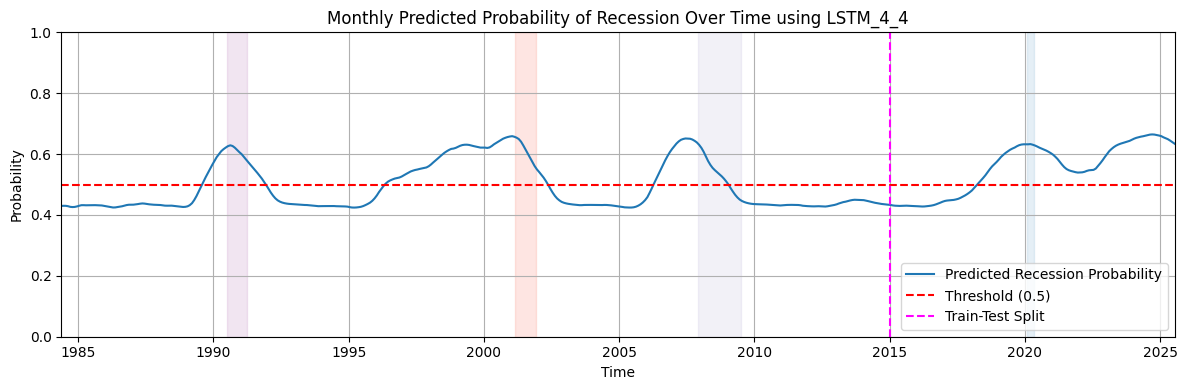

In [12]:
plot_all = True
recessions['start'] = pd.to_datetime(recessions['start'])
recessions['end']   = pd.to_datetime(recessions['end'])

for time_freq, df in dict_features.items():
    X = df.drop(columns='recession')
    y = df['recession']

    # Train-test split
    #split_at = pd.to_datetime('2015-01-01')
    #X_train, X_test = X[X.index < split_at], X[X.index >= split_at]
    #y_train, y_test = y[y.index < split_at].astype(int), y[y.index >= split_at].astype(int)
    X_test = X[X.index >= split_at]
    X_all = X
    
    for model_name in LSTM_models:
        model = LSTM_results[time_freq][model_name]['model']
        scaler = LSTM_results[time_freq][model_name]['scaler']
        
        #X_test_seq, _ = make_sequences(X_test, y=None, seq_len=seq_len)
        #X_test_scaled = scaler.transform(X_test_seq.reshape(-1, X_test.shape[1])).reshape(X_test_seq.shape)
        X_all_seq, _ = make_sequences(X_all, y=None, seq_len=seq_len)
        X_all_scaled = scaler.transform(X_all_seq.reshape(-1, X_all.shape[1])).reshape(X_all_seq.shape)
        #dates_test = X_test.index[seq_len:]

        print(f"X_test_seq: {len(X_test_seq)} vs X_test_scaled: {len(X_test_scaled)}")
        print(f"X_all_seq: {len(X_all_seq)} vs X_all_scaled: {len(X_all_scaled)}")
        #print(f"X_all_scaled: {len(X_all_scaled[X_all_seq.index >= split_at])}")


        probs_all = model.predict(X_all_scaled, verbose=0)
        dates_all = X_all.index[seq_len:]
        prob_series_all  = pd.Series(probs_all.flatten(), index=dates_all)

        if plot_all == True:#export_config['All or Test dataset for plots']['print'] == True:
            prob_series = prob_series_all
            recessions_to_plot = recessions.copy()

        else:
            dates_test = X_test.index[seq_len:]
            print(dates_test)
            probs_test = prob_series_all.loc[dates_test]
            start, end = probs_test.index.min(), probs_test.index.max()
            print(f"{start}, {end}")
            mask = (recessions['start'] <= end) & (recessions['end'] >= start)
            recessions_to_plot = recessions.loc[mask]

            #probs_test = probs_all.loc[dates_test]
            #dates_test = X_all.loc[dates_test]
            #start, end = dates_test.min(), dates_test.max()
            #prob_series = probs_all.loc[start:end]
            #mask = (recessions['start'] <= end) & (recessions['end'] >= start)
            #recessions_to_plot = recessions.loc[mask]
#
            ##probs_test = model.predict(X_test_scaled, verbose=0)
            ##dates_test = X_test.index[seq_len:]
            #prob_series = pd.Series(probs_test.flatten(), index=dates_test)
            #start, end = prob_series.index.min(), prob_series.index.max()
            #mask = (recessions['start'] <= end) & (recessions['end'] >= start)
            #recessions_to_plot = recessions.loc[mask]




        fig, ax = plt.subplots(figsize=(12, 4))
        ax.plot(prob_series, label='Predicted Recession Probability')
        ax.axhline(y=0.5, color='r', linestyle='--', label='Threshold (0.5)')
        #split_at = train_test_split
        ax.axvline(x=split_at, color='magenta', linestyle='--', label='Train-Test Split')

        if recessions is not None:
            print(recessions_to_plot)
            for row in recessions_to_plot.itertuples(index=False):
                ax.axvspan(pd.to_datetime(row.start), pd.to_datetime(row.end), color=row.color, alpha=0.2)



        ax.set_title(f'{time_freq} Predicted Probability of Recession Over Time using {model_name}')
        ax.set_xlabel('Time')
        ax.set_ylabel('Probability')
        ax.set_xlim(prob_series.index.min(), prob_series.index.max())
        ax.set_ylim(0, 1)
        ax.legend(loc='lower right')
        ax.grid(True)
        plt.tight_layout()
        plt.show()




In [13]:
        probs_all = model.predict(X_all_scaled, verbose=0)
        dates_all = X_all.index[seq_len:]
        prob_series = pd.Series(probs_all.flatten(), index=dates_all)

        if plot_all == True:#export_config['All or Test dataset for plots']['print'] == True:

            recessions_to_plot = recessions.copy()

        else:
            probs_test = model.predict(X_test_scaled, verbose=0)
            dates_test = X_test.index[seq_len:]
            prob_series = pd.Series(probs_test.flatten(), index=dates_test)
            start, end = prob_series.index.min(), prob_series.index.max()
            mask = (recessions['start'] <= end) & (recessions['end'] >= start)
            recessions_to_plot = recessions.loc[mask]